# Project 05: Forecasting Morphogenesis in Latent and Image Space

Three main classes:
1. **DataModule:** Manages all data loading, processing, and batching.
2. **ForecasterModel:** Defines the PyTorch model architecture.
3. **Trainer:** Handles the training and validation loops.

Initial imports and Setup:

In [1]:
import os
import gdown
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from pytorch_msssim import ssim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms.functional as TF
import random
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Module Class

* Downloading the data.
* Loading and normalizing the .tif stacks.
* Calculating metadata (timestamps) for each frame.
* Plotting the stacks.
* Creating input/output sequences (X, y).
* Splitting data into training and validation sets.
* Creating the final PyTorch DataLoaders.

In [2]:
class DataModule:
    """
    Handles dowloading, loading, processing, plotting, and batching of embryo data
    """
    def __init__(self, folder_id, data_dir="data", t_start=120, t_end=960):
        """
        Initialized the DataModule.
        
        Args:
        folder_id (str): Google Drive folder ID for the data.
        data_dir (str): Local directory to store downloaded data.
        t_start (int): Timestamp of the first frame (in minutes).
        t_end (int): Timestamp of the last frame (in minutes).
        
        Attributes:
        folder_id (str): Google Drive folder ID.
        data_dir (str): Local directory path for data.
        t_start (int): Start time (minutes) mapped to frame 0.
        t_end (int): End time (minutes) mapped to the last frame.
        embryo_files (List[str]): Sorted list of .tif filenames found in data_dir.
        normalized_data (Dict[str, np.ndarray]): Dict mapping embryo name -> normalized stack (N, H, W) in [0,1].
        metadata_timestamps (Dict[str, np.ndarray]): Dict mapping embryo name -> timestamps array (N,) in minutes.
        """
        self.folder_id = folder_id
        self.data_dir = data_dir
        self.t_start = t_start
        self.t_end = t_end
        
        self.embryo_files = []
        self.normalized_data = {}
        self.metadata_timestamps = {}
        
        print(f"DataModule initialized. Data will be stored in '{self.data_dir}'.")
        
    
    def _download_data(self):
        """
        Downloads data from Google Drive if it doesn't already exist.
        """
        if os.path.exists(self.data_dir):
            print(f"Directory '{self.data_dir}' already exists.")
        else:
            os.makedirs(self.data_dir)
            print(f"Created directory '{self.data_dir}'.")
        # If directory is empty, download
        if not os.listdir(self.data_dir):
            url = f"https://drive.google.com/drive/folders/{self.folder_id}"
            gdown.download_folder(url, output=self.data_dir, quiet=False)
            print("Download complete.")
        else:
            print("Data directory is not empty, skipping download.")
        
        self.embryo_files = sorted([f for f in os.listdir(self.data_dir) if f.endswith('.tif')])
        print(f"Found {len(self.embryo_files)} embryo files.")
        

    def _calculate_timestamps(self, num_frames):
        """
        Calculates a linear interpolation of time for each frame.
        
        Args:
        num_frames (int): Number of frames (N) in the stack.

        Returns:
        np.ndarray: Array of shape (N,) with timestamps (in minutes), linearly spaced from frame 0 to frame N-1.

        """
        return np.linspace(self.t_start, self.t_end, num_frames)

    def load_and_process_data(self):
        """
        Loads all TIF files, normalizes them, and calculates timestamps for each embryo.
        """
        self._download_data()
        
        for name in self.embryo_files:
            file_path = os.path.join(self.data_dir, name)
            # Load the stack
            stack = tiff.imread(file_path)
    
            # Normalize the stack (Uint8: max pixel value 255)
            normalized_stack = stack.astype("float32") / 255.0
    
            # Calculate timestamps
            num_frames = len(normalized_stack)
            timestamps = self._calculate_timestamps(num_frames)
            
            # Save in dictionaries
            key_name = name.split('.')[0]
            self.normalized_data[key_name] = normalized_stack
            self.metadata_timestamps[key_name] = timestamps
    
    def visualize_embryo(self, embryo_name):
        """
        Plots the first, middle, and last frames for a given embryo.
        
        Args:
        embryo_name (str): Key name of the embryo stack to visualize.
        """
        if embryo_name not in self.normalized_data:
            print(f"Error: Embryo '{embryo_name}' not found.")
            return

        stack = self.normalized_data[embryo_name]
        timestamps = self.metadata_timestamps[embryo_name]
        # Frames explored
        time_points = [0, len(stack) // 2, len(stack) - 1]
        
        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i, tp_index in enumerate(time_points):
            ax = axes[i]
            frame = stack[tp_index]
            timestamp_min = timestamps[tp_index]
            
            ax.imshow(frame, cmap='gray', vmin=0, vmax=1)
            ax.set_title(f"Frame: {tp_index}\nTime: {timestamp_min:.2f} min")
            ax.axis("off")
            
        plt.suptitle(f"Visualization of {embryo_name}", fontsize=16)
        plt.tight_layout()
        plt.show()

    def _create_sequences(self, data_stack, n_past, n_future):
        """
        Creates sliding-window sequences (X, y) from a normalized stack.
        
        Args:
        data_stack (np.ndarray): Array of shape (N, H, W).
        n_past (int): Number of past frames in each input sequence.
        n_future (int): Number of future frames to predict.

        Returns:
        Tuple[np.ndarray, np.ndarray]:
        X_all: Array of shape (n_samples, n_past, H, W)
        y_all: Array of shape (n_samples, n_future, H, W)
        """
        X_list, y_list = [],[]
        total_frames = len(data_stack)

        for i in range(total_frames - n_past - n_future + 1):
            past_start = i
            past_end = past_start + n_past
            future_start = past_end
            future_end = future_start + n_future

            X_seq = data_stack[past_start : past_end]
            y_seq = data_stack[future_start : future_end]
            X_list.append(X_seq)
            y_list.append(y_seq)

        return np.array(X_list), np.array(y_list)

    def prepare_dataloaders(self, train_val_names, test_names, 
                              n_past, n_future, train_split_percent, batch_size,
                              use_augmentation: bool = False): # <-- NEW SWITCH
        """
        Prepares Train, Validation, and Test DataLoaders from lists of embryo names.

        - Train/Val sets are created by pooling embryos from 'train_val_names'.
          Each embryo in this list is individually split using 'train_split_percent'.
        - Test set is created by pooling 100% of all embryos from 'test_names'.
        - If 'use_augmentation' is True, applies on-the-fly flips ONLY to the training set.

        Args:
            train_val_names (List[str]): List of embryo names for Training and Validation.
            test_names (List[str]): List of embryo names for Testing.
            n_past (int): Number of past frames in each input sequence.
            n_future (int): Number of future frames to predict.
            train_split_percent (float): Fraction of each Train/Val embryo to use for training.
            batch_size (int): Batch size for all loaders.
            use_augmentation (bool, optional): If True, applies random flips to the
                                               training set. Defaults to False.

        Returns:
            None. Sets class attributes:
            self.train_loader, self.val_loader, self.test_loader
            self.train_dataset, self.val_dataset, self.test_dataset
        """
        self.train_val_names = train_val_names
        self.test_names = test_names
        self.n_past = n_past
        self.n_future = n_future
        self.train_split_percent = train_split_percent

        # --- Helper function to convert sequences to tensors ---
        def _to_torch_tensors(X_seqs, y_seqs):
            """Converts numpy sequence arrays to formatted torch tensors."""
            if not isinstance(X_seqs, np.ndarray) or X_seqs.size == 0:
                # Return empty tensors if list was empty
                return torch.empty(0), torch.empty(0)
            
            # Add channel dim: (N, T, H, W) -> (N, T, H, W, 1)
            X_np = np.expand_dims(X_seqs, axis=-1)
            y_np = np.expand_dims(y_seqs, axis=-1)

            # Move channel dim: (N, T, H, W, 1) -> (N, T, 1, H, W)
            X_np = np.moveaxis(X_np, -1, 2)
            y_np = np.moveaxis(y_np, -1, 2)
            
            X_tensor = torch.from_numpy(X_np).float()
            y_tensor = torch.from_numpy(y_np).float()
            
            # Squeeze 'n_future' dim: (N, 1, C, H, W) -> (N, C, H, W)
            if y_tensor.dim() == 5 and self.n_future == 1:
                y_tensor = y_tensor.squeeze(1)
            return X_tensor, y_tensor
        
        # Prepare Train/Val Data (Pooled)
        print("Preparing Train/Val data...")
        X_train_list, y_train_list = [], []
        X_val_list,   y_val_list   = [], []

        for name in train_val_names:
            if name not in self.normalized_data:
                print(f"  Warning: Embryo '{name}' not found in normalized_data. Skipping.")
                continue
            
            print(f"  - Processing '{name}' for Train/Val split...")
            stack = self.normalized_data[name]
            X_all, y_all = self._create_sequences(stack, n_past, n_future)
            
            if len(X_all) == 0:
                print(f"  Warning: No sequences created for '{name}'. Skipping.")
                continue

            split_index = int(len(X_all) * train_split_percent)
            
            X_train_list.append(X_all[:split_index])
            y_train_list.append(y_all[:split_index])
            X_val_list.append(X_all[split_index:])
            y_val_list.append(y_all[split_index:])

        # Concatenate all embryos for Train/Val
        X_train_seqs = np.concatenate(X_train_list, axis=0) if X_train_list else np.array([])
        y_train_seqs = np.concatenate(y_train_list, axis=0) if y_train_list else np.array([])
        X_val_seqs   = np.concatenate(X_val_list, axis=0) if X_val_list else np.array([])
        y_val_seqs   = np.concatenate(y_val_list, axis=0) if y_val_list else np.array([])

        print(f"  Total Training sequences: {len(X_train_seqs)}")
        print(f"  Total Validation sequences: {len(X_val_seqs)}")

        # Prepare Test Data (Pooled)
        print("Preparing Test data...")
        X_test_list, y_test_list = [], []

        for name in test_names:
            if name not in self.normalized_data:
                print(f"  Warning: Embryo '{name}' not found in normalized_data. Skipping.")
                continue
            
            print(f"  - Processing '{name}' for Test set...")
            stack = self.normalized_data[name]
            X_all, y_all = self._create_sequences(stack, n_past, n_future)
            
            X_test_list.append(X_all)
            y_test_list.append(y_all)
        
        # Concatenate all embryos for Test
        X_test_seqs = np.concatenate(X_test_list, axis=0) if X_test_list else np.array([])
        y_test_seqs = np.concatenate(y_test_list, axis=0) if y_test_list else np.array([])
        
        print(f"  Total Test sequences: {len(X_test_seqs)}")

        # Convert all to Tensors ---
        X_train_tensor, y_train_tensor = _to_torch_tensors(X_train_seqs, y_train_seqs)
        X_val_tensor,   y_val_tensor   = _to_torch_tensors(X_val_seqs, y_val_seqs)
        X_test_tensor,  y_test_tensor  = _to_torch_tensors(X_test_seqs, y_test_seqs)

        # Create Datasets and DataLoaders 
        self.train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        self.val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
        self.test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

        
        # Decide which dataset to use for the train_loader
        if use_augmentation:
            print("  -> Training data will be augmented.")
            try:
                # Wrap the clean training dataset for on-the-fly augmentation
                dataset_for_train_loader = AugmentedSequenceDataset(self.train_dataset)
            except NameError as e:
                print("\n!!! FATAL ERROR: AugmentedSequenceDataset class is not defined. !!!")
                print("!!! Please define the class in a cell BEFORE DataModule. !!!")
                print(f"Error details: {e}")
                # Fallback to un-augmented data to avoid crashing
                dataset_for_train_loader = self.train_dataset
        else:
            print("  -> Training data will NOT be augmented.")
            dataset_for_train_loader = self.train_dataset
            

        # Create the final DataLoaders
        self.train_loader = DataLoader(dataset_for_train_loader, batch_size=batch_size, shuffle=True)
        self.val_loader   = DataLoader(self.val_dataset, batch_size=batch_size, shuffle=False)
        self.test_loader  = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)
        
        print(f"DataLoaders created with batch_size={batch_size}.")

### Data Augmentation Wrapper Class

This class serves as a wrapper around our "clean" training dataset. Its purpose is to apply on-the-fly data augmentation to our sequences.

Crucially, it performs **"lock-step" transformations**, meaning the *same* random spatial augmentation (e.g., a horizontal flip) is applied to all frames in the input sequence (`X`) and its corresponding target frame (`y`). This teaches the model spatial invariance.

In [3]:
class AugmentedSequenceDataset(torch.utils.data.Dataset):
    """
    Wraps a standard TensorDataset to apply "lock-step"
    spatial augmentations (flips) on-the-fly.
    
    This should ONLY be used for the training dataset, as validation
    and test sets must remain consistent (un-augmented).
    """
    def __init__(self, tensor_dataset):
        """
        Args:
            tensor_dataset (torch.utils.data.TensorDataset): 
                The clean training dataset to wrap.
        """
        self.tensor_dataset = tensor_dataset
        # We don't print here; the DataModule will handle printing.
    
    def __len__(self):
        """Returns the length of the wrapped dataset."""
        return len(self.tensor_dataset)

    def __getitem__(self, idx):
        """
        Retrieves one item (X, y) and applies random augmentations.
        
        Args:
            idx (int): The index of the item to retrieve.
            
        Returns:
            (torch.Tensor, torch.Tensor): The augmented (X_seq, y_frame) pair.
        """
        # 1. Get the original, clean data from the wrapped dataset
        # X_seq shape: (T, C, H, W)
        # y_frame shape: (C, H, W)
        X_seq, y_frame = self.tensor_dataset[idx]
        
        # 2. Apply Horizontal Flip (50% chance)
        if random.random() > 0.5:
            # TF.hflip works on tensors of shape (..., H, W)
            # It will correctly flip all T frames in X_seq "in lock-step"
            X_seq = TF.hflip(X_seq)
            # Flip the y frame in the exact same way
            y_frame = TF.hflip(y_frame)
            
        # 3. Apply Vertical Flip (50% chance)
        if random.random() > 0.5:
            X_seq = TF.vflip(X_seq)
            y_frame = TF.vflip(y_frame)
        
        # Note: You could also add 90-degree rotations here
        # if random.random() > 0.5:
        #     # Get a random 90-degree rotation (0, 90, 180, 270)
        #     k = random.randint(1, 3) # 1, 2, or 3
        #     X_seq = TF.rotate(X_seq, k * 90)
        #     y_frame = TF.rotate(y_frame, k * 90)
        
        return X_seq, y_frame

## Forecaster Model Class
This section defines then neural network architecture. It'll port three functions:
* ConvLSTMCell: The core convolutional LSTM cell. Initialize the hidden and cell state with 0's. Update thehidden and cell state for a single time step.
* ConvLSTM: The module that stacks cells and unrolls them over time.
* Forecaster: The final model that wraps the ConvLSTM and adds a predictive 2D convolution layer.

In [4]:
class ConvLSTMCell(nn.Module):
    """
    Basic ConvLSTM cell.
    
    Parameters:
    input_dim (int): Number of channels of input tensor.
    hidden_dim (int): Number of channels of hidden state.
    kernel_size (int, int): Size of the convolutional kernel.
    bias (bool): Whether or not to add the bias.
    """
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        # Calculate padding to keep spatial dimensions the same ("same" padding)
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        # This single convolution layer computes all 4 gates at once: (input, forget, output, cell) 
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)
    
    def forward(self, input_tensor, cur_state):
        """
        Updating the cell and hidden state for a single time step.
        
        Args:
            input_tensor (torch.Tensor): Input tensor for the current time step. 
                                         Shape: (B, C_in, H, W)
            cur_state (tuple): (h_cur, c_cur)
                h_cur (torch.Tensor): Hidden state from previous time step. 
                                      Shape: (B, C_hidden, H, W)
                c_cur (torch.Tensor): Cell state from previous time step.
                                      Shape: (B, C_hidden, H, W)
        
        Returns:
            (h_next, c_next): Next hidden and cell states.
        """
        h_cur, c_cur = cur_state

        # Concatenate input and hidden state along the channel dimension
        # (B, C_in, H, W) + (B, C_hidden, H, W) -> (B, C_in + C_hidden, H, W)
        combined = torch.cat([input_tensor, h_cur], dim=1)
        
        # Apply the convolution
        combined_conv = self.conv(combined)
        
        # Split the result into the 4 gates (i, f, o, g)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        
        # Apply activation functions
        i = torch.sigmoid(cc_i)  # Input gate
        f = torch.sigmoid(cc_f)  # Forget gate
        o = torch.sigmoid(cc_o)  # Output gate
        g = torch.tanh(cc_g)     # Cell gate

        # Calculate the next cell state and hidden state
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        """
        Initializes the (h, c) states with zeros.
        
        Args:
            batch_size (int): Batch size.
            image_size (tuple): (height, width) of the image.
            
        Returns:
            (torch.Tensor, torch.Tensor): A tuple of zero-filled Tensors 
                                          for (h_0, c_0).
        """
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=device))

In [5]:
class ConvLSTM(nn.Module):
    """
    Full ConvLSTM module that wraps ConvLSTMCell. It takes ConvLSTMCell and unroll the sequence in time and stack multiple layers.

    Parameters:
        input_dim (int): Number of channels in input (monochrome/RGB)
        hidden_dim (int/list of ints): Number of hidden channels (can be a list for multiple layers)
        kernel_size (int/list of ints): Size of kernel in convolutions (can be a list for multiple layers)
        num_layers int: Number of LSTM layers stacked on each other
        batch_first (bool): Whether or not dimension 0 is the batch (True) or not (False)
        bias (bool): Bias or no bias in Convolution
        return_all_layers (bool): Return the list of computations for all layers or just the last output
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that kernel_size and hidden_dim are lists of len num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        # Create the list of cell layers
        cell_list = []
        for i in range(0, self.num_layers):
            # Input dim for the first layer is input_dim, 
            # for subsequent layers it's the hidden_dim of the previous layer.
                if i == 0:
                    cur_input_dim = self.input_dim 
                else: 
                    cur_input_dim = self.hidden_dim[i - 1]

                cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,hidden_dim=self.hidden_dim[i], kernel_size=self.kernel_size[i],bias=self.bias))

        # nn.ModuleList holds all the layers, making them visible to PyTorch
        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Forward pass for a sequence.
        
        Args:
            input_tensor (torch.Tensor): Input sequence. 
                                         Shape: (B, T, C_in, H, W) if batch_first=True
            hidden_state (list, optional): List of (h, c) tuples for each layer.
        
        Returns:
            (layer_output_list, last_state_list)
        """
        # (T, B, C, H, W) -> (B, T, C, H, W) if batch_first=True
        if not self.batch_first:
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Initialize hidden state if not provided
        if hidden_state is None:
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        # Loop over layers
        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            
            # Loop over time (sequence length)
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h) # Store the hidden state (output) for this time step

            # Stack all time step outputs
            layer_output = torch.stack(output_inner, dim=1)
            
            # This layer's output becomes the next layer's input
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c]) # Store the final (h, c) of the layer

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:] # Only return the last layer's output
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        """Initializes hidden state for all layers."""
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        """Helper function to check kernel_size type."""
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        """Helper function to ensure a param is a list of len num_layers."""
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

**Forecaster:**

In [6]:
class Forecaster(nn.Module):
    """
    Final Forecaster model.
    It wraps the ConvLSTM and adds a final 2D Conv layer for prediction.
    
    Parameters:
        input_dim (int): Number of channels in input (e.g., 1 for grayscale)
        hidden_dims (int/list of ints): List of hidden channels for each ConvLSTM layer (e.g., [16, 32])
        kernel_size ([int,int]): Kernel size for ConvLSTM (e.g., (3, 3))
        num_layers (int): Number of ConvLSTM layers.
    """
    def __init__(self, input_dim, hidden_dims, kernel_size, num_layers):
        super(Forecaster, self).__init__()
        
        # The ConvLSTM engine 
        self.convlstm = ConvLSTM(
            input_dim=input_dim,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=num_layers,
            batch_first=True,  
            bias=True,
            return_all_layers=False # Only last layer's output
        )
        
        # The final prediction layer
        # This layer takes the output from the last ConvLSTM layer
        # back to our 'input_dim' (1 channel).
        self.final_conv = nn.Conv2d(
            in_channels=hidden_dims[-1], # Output channels from the last LSTM layer
            out_channels=input_dim,      # 1 output channel (our prediction)
            kernel_size=(3, 3),          # 3x3 kernel
            padding=1                    # 'Same padding' to keep size
        )

    def forward(self, x):
        """
        Forward pass for the complete model.
        
        Args:
            x (torch.Tensor): Input sequence tensor.
                              Shape: (B, T, C, H, W)
                              
        Returns:
            torch.Tensor: The predicted frame.
                          Shape: (B, C, H, W)
        """
        
        # Pass the sequence through the ConvLSTM engine
        layer_output, last_states = self.convlstm(x)
        
        # Take the LAST time step
        last_time_step_output = layer_output[0][:, -1, :, :, :]
        
        # Pass through the final layer
        prediction = self.final_conv(last_time_step_output)
        
        # Use Sigmoid
        return torch.sigmoid(prediction)

## Trainer Class:
Takes all the objects we've built so far (model, optimizer, loss_fn, and the DataModule loaders) and runs the training loop, storing the loss history along the way.

In [7]:
class Trainer:
    """
    Handles the model training, validation, and final testing loops.
    
    This class encapsulates all the logic for training, evaluating,
    managing the learning rate scheduler, and running detailed per-embryo tests.
    """
    
    def __init__(self, 
                 model: nn.Module, 
                 data_module: 'DataModule', # <-- CHANGED: Pass the whole module
                 loss_fn: callable, 
                 optimizer: torch.optim.Optimizer, 
                 device: torch.device):
        """
        Initializes the Trainer.

        Args:
            model (nn.Module): The model to train.
            data_module (DataModule): The instantiated DataModule object.
                                      This is used to access loaders and metadata.
            loss_fn (callable): The loss function (e.g., nn.L1Loss()).
            optimizer (torch.optim.Optimizer): The optimizer (e.g., Adam).
            device (torch.device): The device (cpu or cuda) to run training on.
        """
        self.model = model.to(device)
        self.data_module = data_module
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device
        
        # Get loaders directly from the data_module
        self.train_loader = self.data_module.train_loader
        self.val_loader = self.data_module.val_loader
        self.test_loader = self.data_module.test_loader 
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', 
                                           patience=3, 
                                           factor=0.1)
        
        # History lists to store loss values
        self.train_losses = []
        self.val_losses = []
        
        print(f"Trainer initialized. Device: {self.device}")


    def _train_one_epoch(self) -> float:
        """Runs one full pass over the training data."""
        self.model.train()
        running_train_loss = 0.0
        for X_batch, y_batch in self.train_loader:
            X_batch = X_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            self.optimizer.zero_grad()
            predictions = self.model(X_batch)
            loss = self.loss_fn(predictions, y_batch)
            loss.backward()
            self.optimizer.step()
            running_train_loss += loss.item()
        return running_train_loss / len(self.train_loader)

    def _validate_one_epoch(self) -> float:
        """Runs one full pass over the validation data."""
        self.model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in self.val_loader:
                X_val_batch = X_val_batch.to(self.device)
                y_val_batch = y_val_batch.to(self.device)
                val_preds = self.model(X_val_batch)
                val_loss = self.loss_fn(val_preds, y_val_batch)
                running_val_loss += val_loss.item()
        return running_val_loss / len(self.val_loader)

    def train(self, num_epochs: int):
        """Runs the main training loop (train + validation)."""
        print(f"Starting training for {num_epochs} epochs...")
        for epoch in range(num_epochs):
            start_time = time.time()
            avg_train_loss = self._train_one_epoch()
            avg_val_loss = self._validate_one_epoch()
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.scheduler.step(avg_val_loss)
            epoch_time = time.time() - start_time
            print(f"Epoch [{epoch+1:02d}/{num_epochs}] - "
                  f"Time: {epoch_time:.2f}s - "
                  f"Train Loss: {avg_train_loss:.8f} - "
                  f"Val Loss: {avg_val_loss:.8f}")
        print("\nTraining complete!")

    def test(self) -> float:
        """
        Runs a final, one-time evaluation on the default (pooled) Test set.
        """
        self.model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_test_batch, y_test_batch in self.test_loader:
                X_test_batch = X_test_batch.to(self.device)
                y_test_batch = y_test_batch.to(self.device)
                test_preds = self.model(X_test_batch)
                loss = self.loss_fn(test_preds, y_test_batch)
                test_loss += loss.item()
        avg_test_loss = test_loss / len(self.test_loader)
        print(f"Average Pooled Test Loss: {avg_test_loss:.8f}  ")
        return avg_test_loss
    
    def run_per_embryo_test_and_visualize(self, visualize_batch: str | int = 'last'):
        """
        Runs a detailed, per-embryo evaluation on the test set.
        
        This method iterates through each embryo in `data_module.test_names`,
        calculates its individual test loss, and visualizes one batch.

        Args:
            visualize_batch (str or int, optional): Which batch to visualize.
                Options: 'first', 'last', 'middle', or a specific int index.
                Defaults to 'last'.
        
        Returns:
            Dict[str, float]: A dictionary mapping embryo names to their avg. test loss.
        """
        self.model.eval() # Set model to evaluation mode
        
        # Get data from the stored DataModule
        test_embryo_list = self.data_module.test_names
        n_past = self.data_module.n_past
        n_future = self.data_module.n_future
        # Get batch size from the *pooled* test loader (safe assumption)
        batch_size = self.test_loader.batch_size 
        
        final_test_losses = {} # A dictionary to store the results

        # Loop over each test embryo
        for embryo_name in test_embryo_list:
            print(f"STARTING TEST FOR: {embryo_name}")

            # Create a temporary Dataset and DataLoader
            try:
                stack = self.data_module.normalized_data[embryo_name]
            except KeyError:
                print(f"Warning: Embryo '{embryo_name}' not found. Skipping.")
                continue

            # Create sequences (100% of them)
            X_all_seqs, y_all_seqs = self.data_module._create_sequences(stack, n_past, n_future)
            if len(X_all_seqs) == 0:
                print(f"Warning: No sequences created for '{embryo_name}'. Skipping.")
                continue

            # Replicate the tensor conversion logic from DataModule
            X_np = np.moveaxis(np.expand_dims(X_all_seqs, axis=-1), -1, 2)
            y_np = np.moveaxis(np.expand_dims(y_all_seqs, axis=-1), -1, 2)
            X_tensor = torch.from_numpy(X_np).float()
            y_tensor = torch.from_numpy(y_np).float()
            if y_tensor.dim() == 5 and n_future == 1:
                y_tensor = y_tensor.squeeze(1)

            # Create the temporary (in-memory) Dataset and DataLoader
            temp_dataset = TensorDataset(X_tensor, y_tensor)
            temp_loader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False)

            # Run Quantitative Test (Calculate Loss)
            test_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in temp_loader:
                    X_batch = X_batch.to(self.device)
                    y_batch = y_batch.to(self.device)
                    test_preds = self.model(X_batch)
                    loss = self.loss_fn(test_preds, y_batch)
                    test_loss += loss.item()
            
            avg_test_loss = test_loss / len(temp_loader)
            final_test_losses[embryo_name] = avg_test_loss
            
            print(f"\n  *** RESULT (Quantitative) ***")
            print(f"  -> Average Test Loss for {embryo_name}: {avg_test_loss:.8f}")
            
            if self.loss_fn.__name__ == 'loss_fn': # Check if it's the custom SSIM func
                 print(f"  -> (Equivalent SSIM: {(1 - avg_test_loss):.4f})")

            # Run Qualitative Test
            print(f"\n  *** RESULT (Qualitative) ***")
            print(f"  -> Visualizing batch: '{visualize_batch}'...")

            Xb, yb = None, None
            batch_start_index = 0
            
            # Get the requested batch
            try:
                num_batches = len(temp_loader)
                if num_batches == 0:
                    raise StopIteration("Loader is empty.")
                    
                target_idx = 0 # Default to 'first'
                
                if visualize_batch == 'first':
                    target_idx = 0
                elif visualize_batch == 'last':
                    target_idx = num_batches - 1
                elif visualize_batch == 'middle':
                    target_idx = num_batches // 2
                elif isinstance(visualize_batch, int):
                    if 0 <= visualize_batch < num_batches:
                        target_idx = visualize_batch
                    else:
                        print(f"  Warning: Batch index {visualize_batch} is out of bounds (0-{num_batches-1}). Defaulting to 'last'.")
                        target_idx = num_batches - 1
                else:
                    raise ValueError("visualize_batch must be 'first', 'last', 'middle', or an int.")

                # Iterate and get the target batch
                for i, batch in enumerate(temp_loader):
                    if i == target_idx:
                        Xb, yb = batch
                        batch_start_index = i * batch_size # Get the sequence start index
                        break

            except Exception as e:
                print(f"  Error getting batch: {e}. Skipping visualization.")
                continue

            # Visualization 
            if Xb is not None and yb is not None:
                Xb, yb = Xb.to(self.device), yb.to(self.device)
                with torch.no_grad():
                    y_pred = model(Xb)
                    
                Xb_cpu = Xb.cpu().numpy()
                yb_cpu = yb.cpu().numpy()
                y_pred_cpu = y_pred.cpu().numpy()
                
                all_timestamps = self.data_module.metadata_timestamps[embryo_name]
                n_examples_to_show = Xb.shape[0] # Show all examples in this batch
                
                plt.figure(figsize=(16, 5 * n_examples_to_show))
                
                for i in range(n_examples_to_show):
                    last_input = Xb_cpu[i, -1, 0, :, :]
                    ground_truth = yb_cpu[i, 0, :, :]
                    prediction = y_pred_cpu[i, 0, :, :]
                    error_map = np.abs(prediction - ground_truth)
                    
                    # Get sequence index relative to this embryo's dataset
                    sequence_index = batch_start_index + i 
                    last_input_frame_idx = sequence_index + n_past - 1
                    target_frame_idx = last_input_frame_idx + 1
                    
                    if target_frame_idx < len(all_timestamps):
                        time_t = all_timestamps[last_input_frame_idx]
                        time_t_plus_1 = all_timestamps[target_frame_idx]
                    else:
                        time_t, time_t_plus_1 = -1, -1 # Handle edge case

                    # Plot Titles
                    ax = plt.subplot(n_examples_to_show, 4, i*4 + 1)
                    ax.set_title(f"TEST SET: {embryo_name} | Last Input (x_t)\nFrame: {last_input_frame_idx} | Time: {time_t:.2f} min")
                    ax.imshow(last_input, cmap='gray', vmin=0, vmax=1)
                    ax.axis('off')
                    
                    ax = plt.subplot(n_examples_to_show, 4, i*4 + 2)
                    ax.set_title(f"Ground Truth (Test Set)\nFrame: {target_frame_idx} | Time: {time_t_plus_1:.2f} min")
                    ax.imshow(ground_truth, cmap='gray', vmin=0, vmax=1)
                    ax.axis('off')
                    
                    ax = plt.subplot(n_examples_to_show, 4, i*4 + 3)
                    ax.set_title(f"Prediction (Test Set)\nFrame: {target_frame_idx} | Time: {time_t_plus_1:.2f} min")
                    ax.imshow(prediction, cmap='gray', vmin=0, vmax=1)
                    ax.axis('off')
                    
                    ax = plt.subplot(n_examples_to_show, 4, i*4 + 4)
                    ax.set_title(f"|Error|")
                    ax.imshow(error_map, cmap='hot', vmin=0, vmax=error_map.max())
                    ax.axis('off')
                
                plt.tight_layout()
                plt.show()

        # Print Final Summary
        print(f" FINAL TEST SUMMARY (Per-Embryo):")
        for embryo_name, loss in final_test_losses.items():
            print(f" -> Avg. Test Loss for {embryo_name}: {loss:.8f}")

        return final_test_losses

## Exercise

## 1. Setup and Data Loading

We define the global parameters for our experiment.
- `TRAIN_VAL_NAMES`: A list of embryos to use for training and validation.
- `TEST_NAMES`: A list of embryos reserved *only* for the final test.
- `TRAIN_SPLIT_PERCENT`: The 80/20 split to apply to the `TRAIN_VAL_NAMES` list.
- `USE_AUGMENTATION`: A switch to enable/disable on-the-fly augmentation.

We then instantiate our `DataModule` and call `.load_and_process_data()` to download and normalize all TIF files.

In [8]:
# Parameters:
FOLDER_ID = "1_qxqm-v5yCrme3pAW2rjyOOXIeQDuV54"
TRAIN_VAL_NAMES = ['Control1', 'Mutant1', 'Mutant3'] # Embryos to use for Training and Validation
TEST_NAMES = ['Control2', 'Mutant2', 'Mutant4']      # Embryos reserved for the final Test
N_PAST = 10
N_FUTURE = 1
TRAIN_SPLIT_PERCENT = 0.8 
BATCH_SIZE = 4
USE_AUGMENTATION = True 
NUM_EPOCHS = 40
LEARNING_RATE = 0.001   # Initial learning rate for Adam

# Download, normalize, and calculate timestamps of the TIF stacks:
data_module = DataModule(folder_id=FOLDER_ID)
data_module.load_and_process_data()

DataModule initialized. Data will be stored in 'data'.
Directory 'data' already exists.
Data directory is not empty, skipping download.
Found 6 embryo files.


### 2. Input Data Visualization

We use the `.visualize_embryo()` method to visualize the loaded data.

--- Visualizing Train/Val Embryos (3 total) ---

--- Embryo: Control1 ---


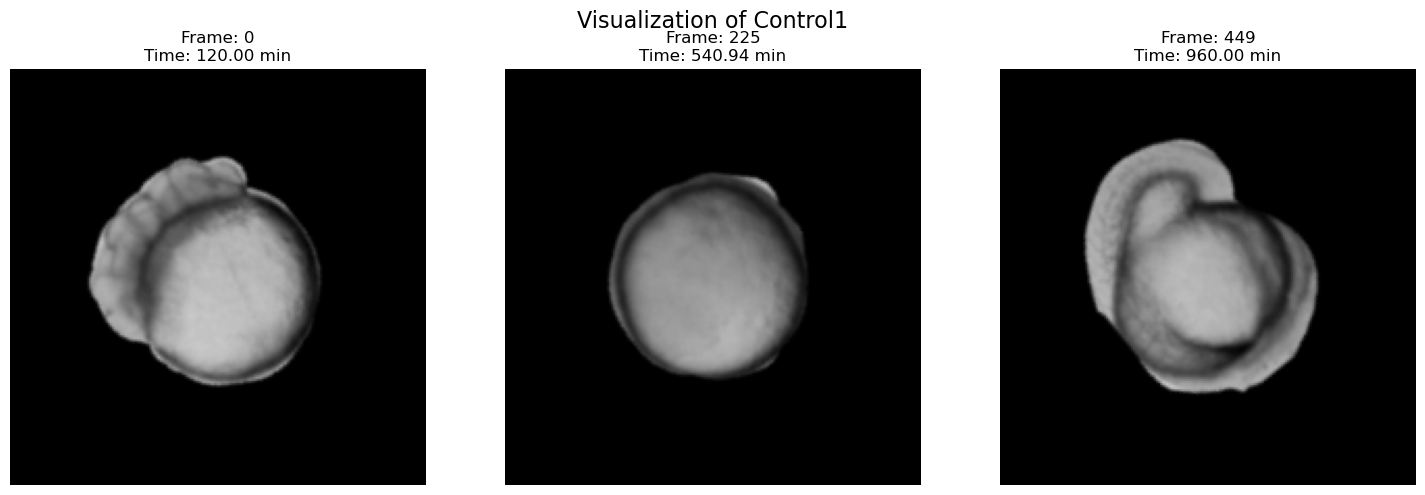


--- Embryo: Mutant1 ---


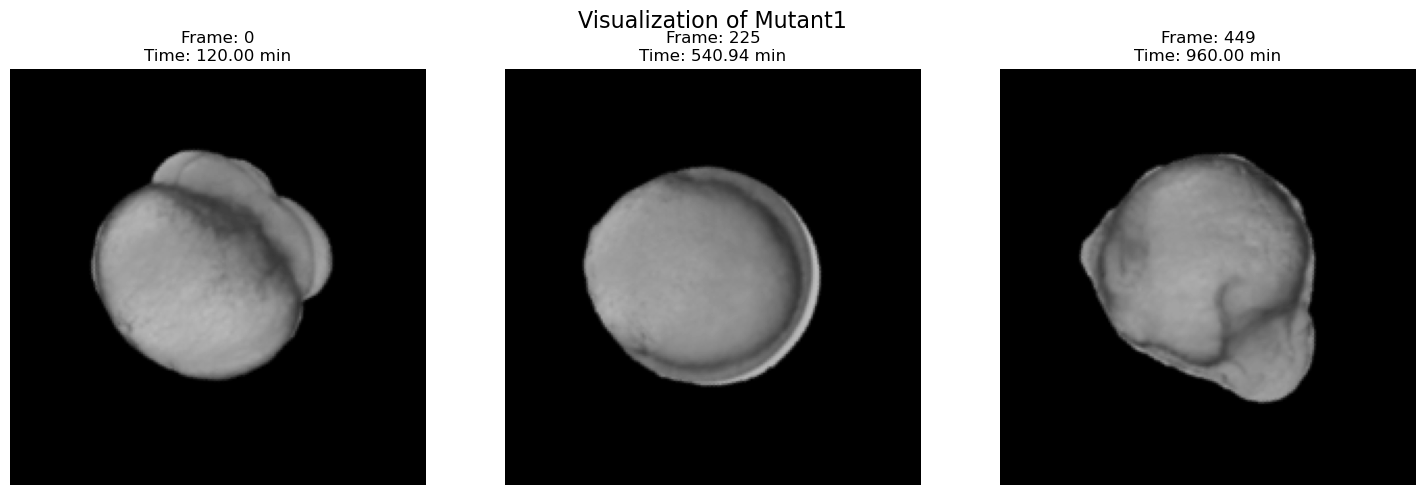


--- Embryo: Mutant3 ---


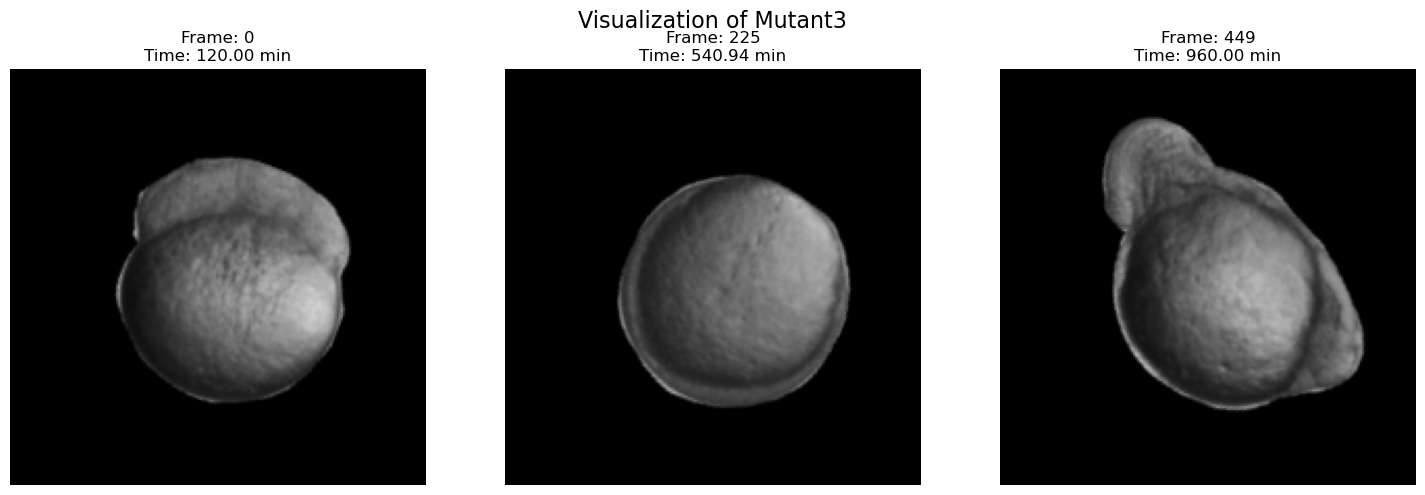


--- Visualizing Test Embryos (3 total) ---

--- Embryo: Control2 ---


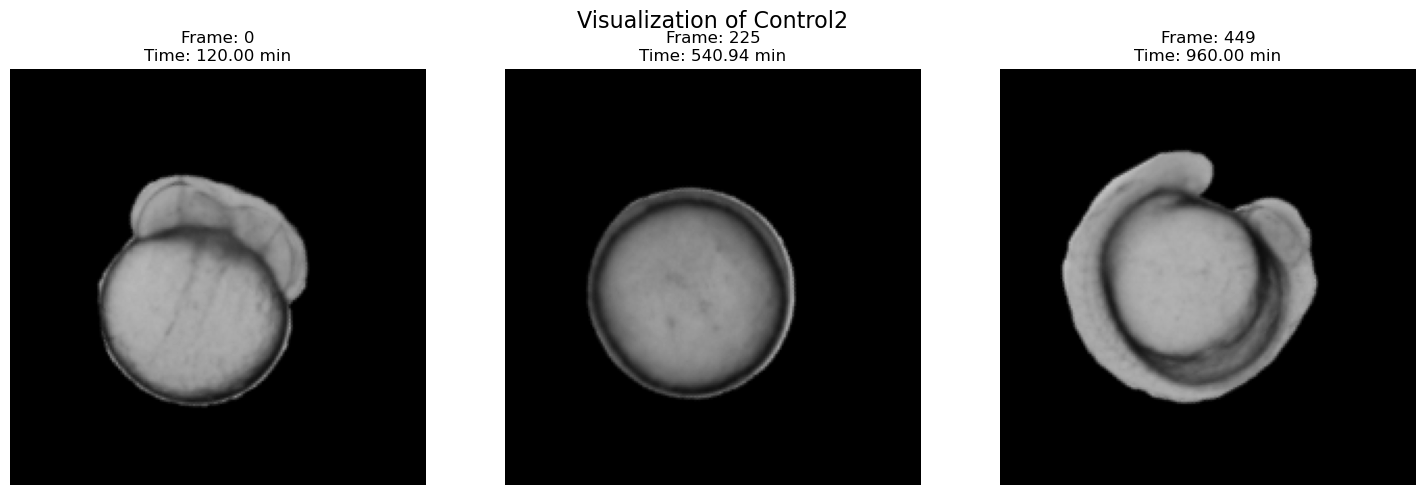


--- Embryo: Mutant2 ---


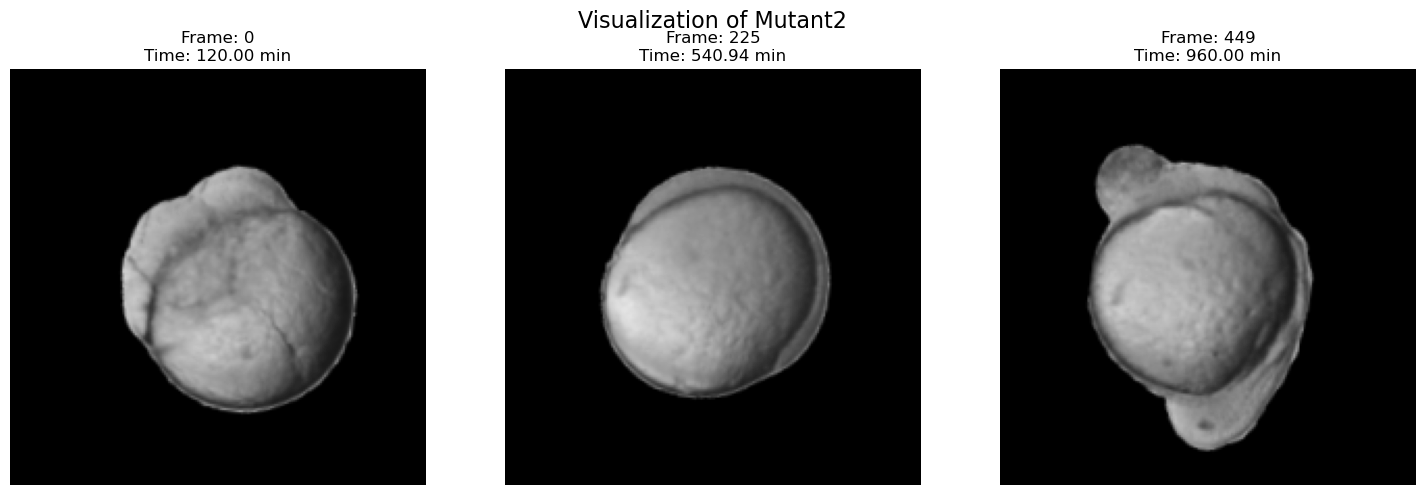


--- Embryo: Mutant4 ---


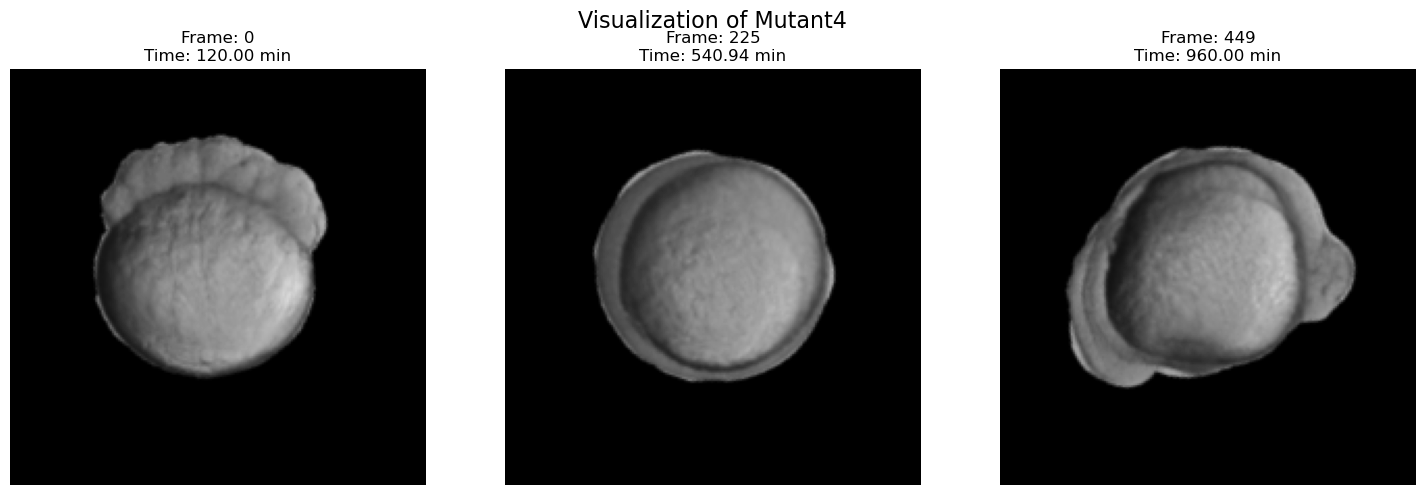

In [9]:
# Plotting the data
print(f"--- Visualizing Train/Val Embryos ({len(TRAIN_VAL_NAMES)} total) ---")
for name in TRAIN_VAL_NAMES:
    print(f"\n--- Embryo: {name} ---")
    data_module.visualize_embryo(name)

print(f"\n--- Visualizing Test Embryos ({len(TEST_NAMES)} total) ---")
for name in TEST_NAMES:
    print(f"\n--- Embryo: {name} ---")
    data_module.visualize_embryo(name)

## 3. Creating Sequences and DataLoaders

We now call `.prepare_dataloaders()` method. This function will:
1.  Take the `TRAIN_VAL_NAMES` list (`['Control1']`) and apply the `TRAIN_SPLIT_PERCENT` (80/20) to create the `train_dataset` and `val_dataset`.
2.  Take the `TEST_NAMES` list (`['Control2']`) and use 100% of its sequences to create the `test_dataset`.
3.  Check the `USE_AUGMENTATION` flag. 

In [10]:
data_module.prepare_dataloaders(
        train_val_names=TRAIN_VAL_NAMES,
        test_names=TEST_NAMES,
        n_past=N_PAST,
        n_future=N_FUTURE,
        train_split_percent=TRAIN_SPLIT_PERCENT,
        batch_size=BATCH_SIZE,
        use_augmentation=USE_AUGMENTATION
    )

Preparing Train/Val data...
  - Processing 'Control1' for Train/Val split...
  - Processing 'Mutant1' for Train/Val split...
  - Processing 'Mutant3' for Train/Val split...
  Total Training sequences: 1056
  Total Validation sequences: 264
Preparing Test data...
  - Processing 'Control2' for Test set...
  - Processing 'Mutant2' for Test set...
  - Processing 'Mutant4' for Test set...
  Total Test sequences: 1320
  -> Training data will be augmented.
DataLoaders created with batch_size=4.


In [11]:
print(f"Train loader (Control1 - 80%): {len(data_module.train_loader)} batches")
print(f"Val loader (Control1 - 20%):   {len(data_module.val_loader)} batches")
print(f"Test loader (Control2 - 100%): {len(data_module.test_loader)} batches")    
# Single batch
X_batch, y_batch = next(iter(data_module.train_loader))
print(f"\nSample Train X_batch shape: {X_batch.shape}")
print(f"Sample Train y_batch shape: {y_batch.shape}")

Train loader (Control1 - 80%): 264 batches
Val loader (Control1 - 20%):   66 batches
Test loader (Control2 - 100%): 330 batches

Sample Train X_batch shape: torch.Size([4, 10, 1, 200, 200])
Sample Train y_batch shape: torch.Size([4, 1, 200, 200])


## 4. Define Model and Optimizer

We set the architecture's hyperparameters (hidden channels, layers) and instantiate our `Forecaster` model.

We will also define the `Adam` optimizer here and the `loss funcion: SSIM`.

In [12]:
# Model Hyperparameters 
IN_CHANNELS = 1      # 1 channel (grayscale)
KERNEL_SIZE = (3, 3) # 3x3 kernel
HIDDEN_DIMS = [32, 64]
NUM_LAYERS = 2

# Forecaster class 
model = Forecaster(
    input_dim=IN_CHANNELS,
    hidden_dims=HIDDEN_DIMS,
    kernel_size=KERNEL_SIZE,
    num_layers=NUM_LAYERS
)

# Move the model to the GPU (device)
model.to(device)

# Loss Function
def loss_fn(y_pred, y_true):
    """
    SSIM-based loss function.
    """
    # data_range=1.0, normalized
    return 1 - ssim(y_pred, y_true, data_range=1.0, size_average=True)
    
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Model:
print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

print("\n Model Architecture ")
print(model)

Total trainable parameters: 260,161

 Model Architecture 
Forecaster(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(33, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (final_conv): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


## 5. Define Trainer and Run Training

This class encapsulates all training and validation logic.
- It takes our `model`, `optimizer`, `loss_fn`, and all `DataLoaders`.
- It automatically manages a `ReduceLROnPlateau` scheduler to adjust the learning rate if the validation loss stalls.
- It has a `.train()` method for the training loop.
- It has a separate `.test()` method for the final evaluation (using `test_loader`).


In [13]:
# Define the Trainer
trainer = Trainer(
        model=model,
        data_module=data_module,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device
    )

# Run the training 
trainer.train(num_epochs=NUM_EPOCHS)

Trainer initialized. Device: cuda
Starting training for 40 epochs...
Epoch [01/40] - Time: 167.17s - Train Loss: 0.17099944 - Val Loss: 0.12058974
Epoch [02/40] - Time: 166.86s - Train Loss: 0.10191391 - Val Loss: 0.11842587
Epoch [03/40] - Time: 166.84s - Train Loss: 0.10068819 - Val Loss: 0.11884111
Epoch [04/40] - Time: 166.86s - Train Loss: 0.10018358 - Val Loss: 0.11734818
Epoch [05/40] - Time: 166.85s - Train Loss: 0.09979307 - Val Loss: 0.11660807
Epoch [06/40] - Time: 166.86s - Train Loss: 0.09936104 - Val Loss: 0.11607059
Epoch [07/40] - Time: 166.84s - Train Loss: 0.09902079 - Val Loss: 0.11600162
Epoch [08/40] - Time: 166.85s - Train Loss: 0.09885051 - Val Loss: 0.11719298
Epoch [09/40] - Time: 166.85s - Train Loss: 0.09863012 - Val Loss: 0.11749754
Epoch [10/40] - Time: 166.85s - Train Loss: 0.09857250 - Val Loss: 0.11573669
Epoch [11/40] - Time: 166.85s - Train Loss: 0.09856878 - Val Loss: 0.11522479
Epoch [12/40] - Time: 166.86s - Train Loss: 0.09825548 - Val Loss: 0.1158

### 6. Plotting Loss Curves

We plot both curves to analyze the model's performance.

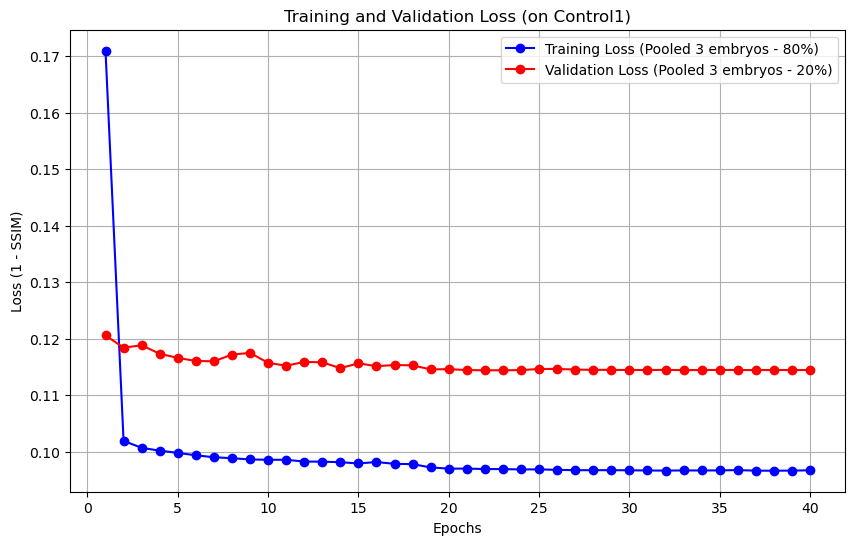

In [14]:
# Get the loss history from the trainer object
train_loss_history = trainer.train_losses
val_loss_history = trainer.val_losses

# Get the number of epochs
epochs = range(1, len(train_loss_history) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_loss_history, 'b-o', label=f'Training Loss (Pooled {len(TRAIN_VAL_NAMES)} embryos - 80%)')
plt.plot(epochs, val_loss_history, 'r-o', label=f'Validation Loss (Pooled {len(TRAIN_VAL_NAMES)} embryos - 20%)')
plt.title('Training and Validation Loss (Pooled Data)')

plt.title('Training and Validation Loss (on Control1)')
plt.xlabel('Epochs')
plt.ylabel('Loss (1 - SSIM)') # Or update if you changed the loss
plt.legend()
plt.grid(True)
plt.show()

## 7. Final Per-Embryo Evaluation on Test Set

This is the final, most important test. We will now iterate through each embryo in our `TEST_NAMES` list.

For each unseen test embryo, we will:
1.  Manually create a dedicated `test_loader` containing only that embryo's sequences.
2.  Run a **quantitative** evaluation to calculate its specific `Average Test Loss`.
3.  Run a **qualitative** visualization on its *last batch* to inspect performance.


STARTING TEST FOR: Control2

  *** RESULT (Quantitative) ***
  -> Average Test Loss for Control2: 0.07112371
  -> (Equivalent SSIM: 0.9289)

  *** RESULT (Qualitative) ***
  -> Visualizing batch: 'last'...


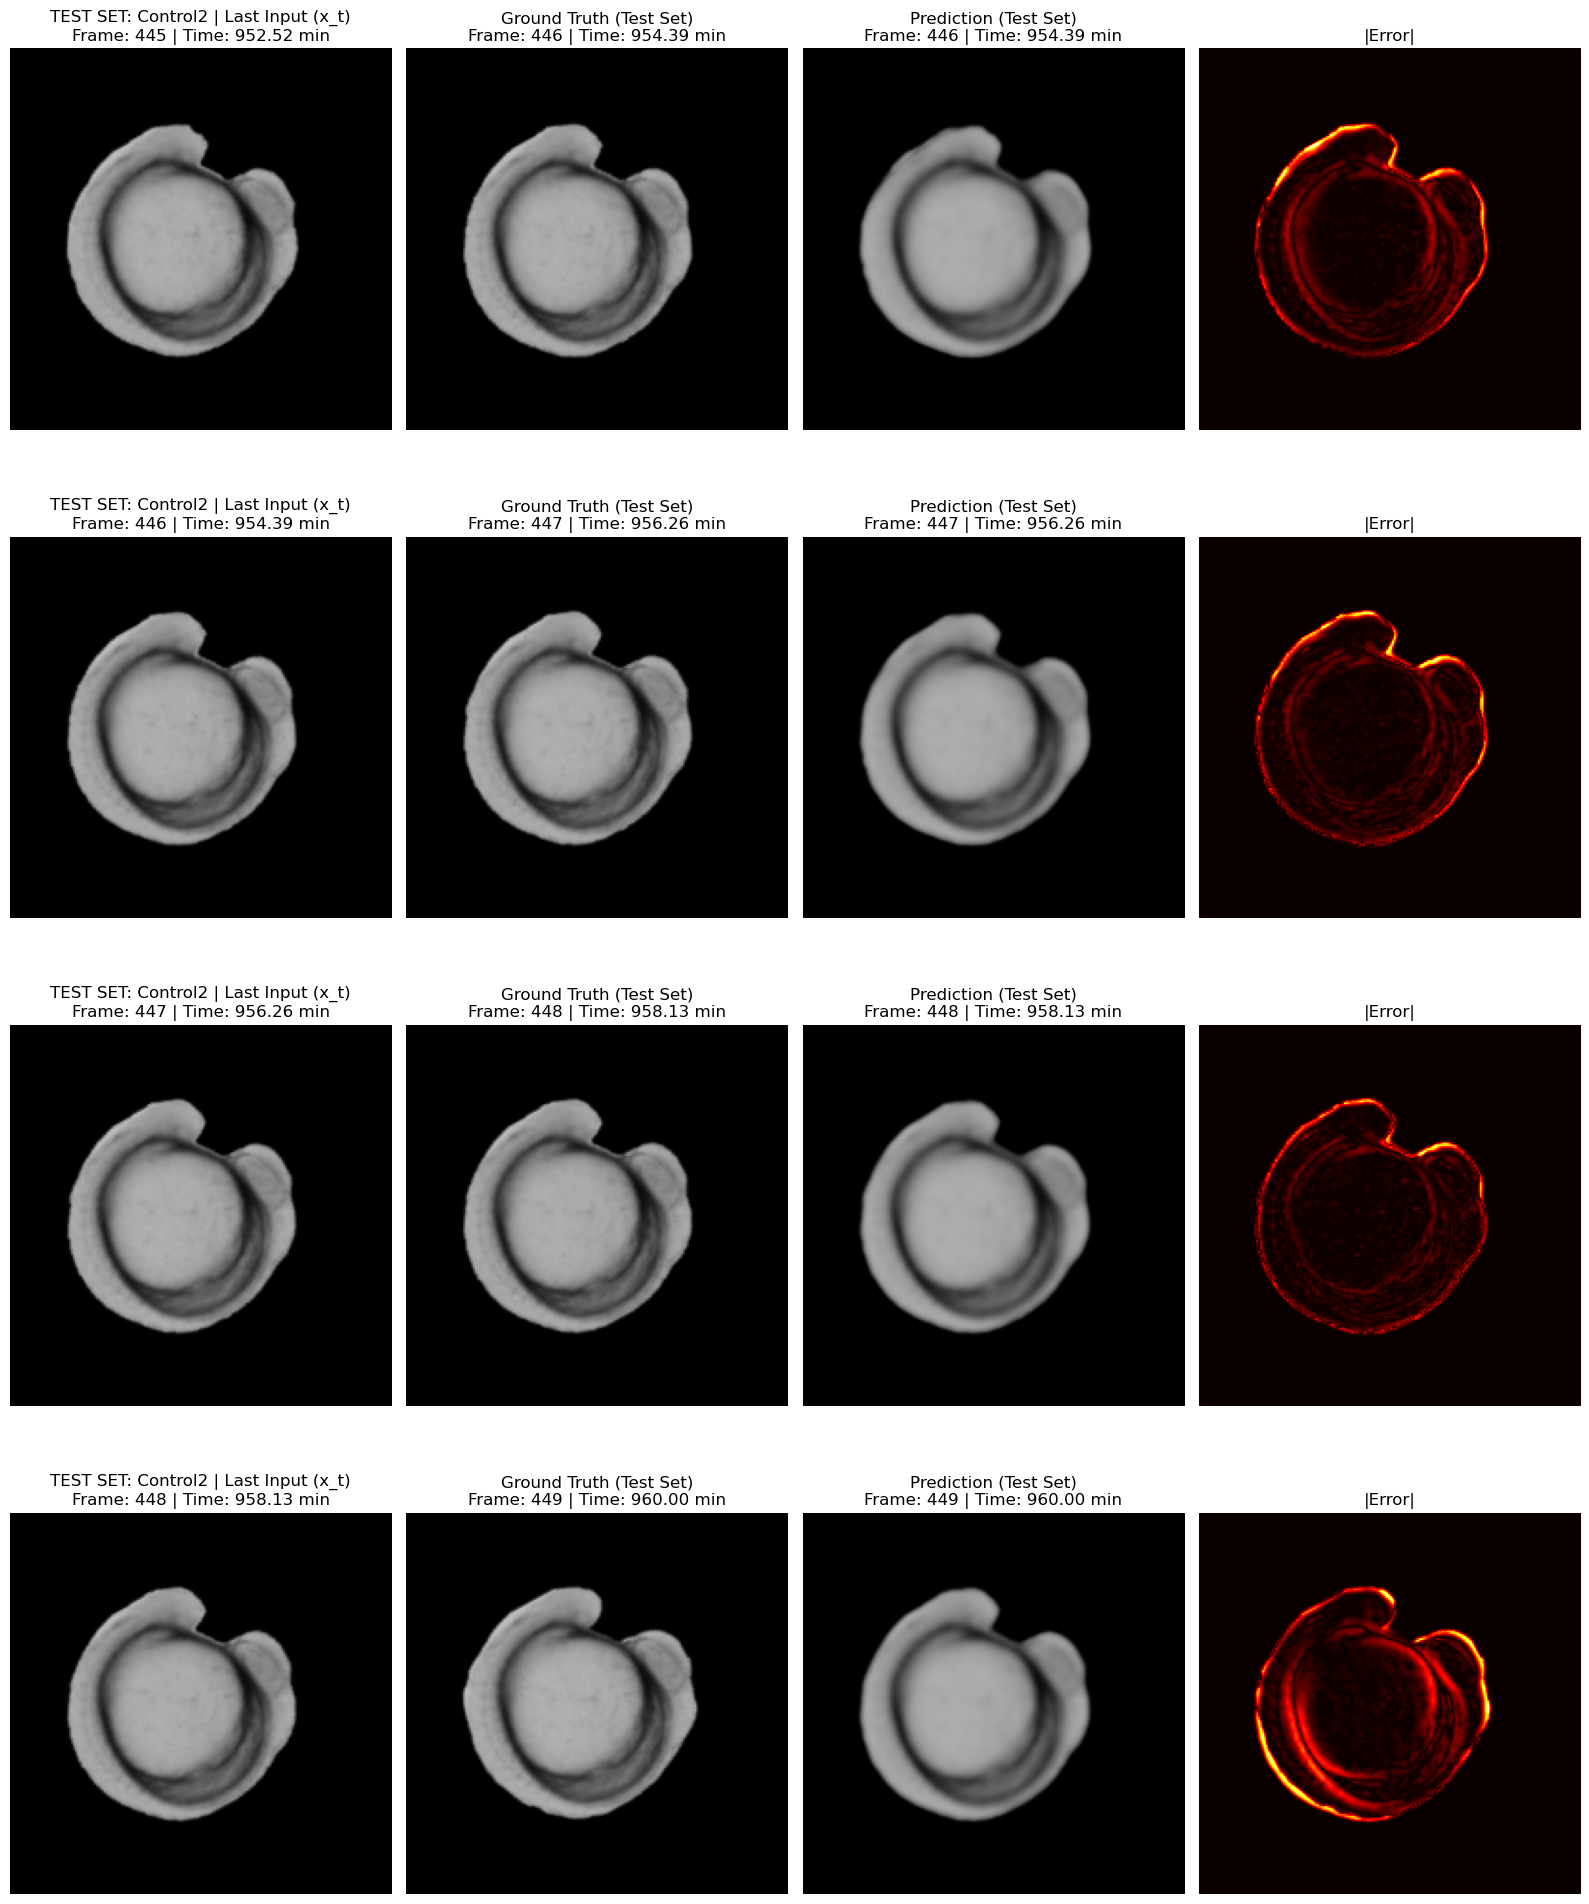

STARTING TEST FOR: Mutant2

  *** RESULT (Quantitative) ***
  -> Average Test Loss for Mutant2: 0.09604156
  -> (Equivalent SSIM: 0.9040)

  *** RESULT (Qualitative) ***
  -> Visualizing batch: 'last'...


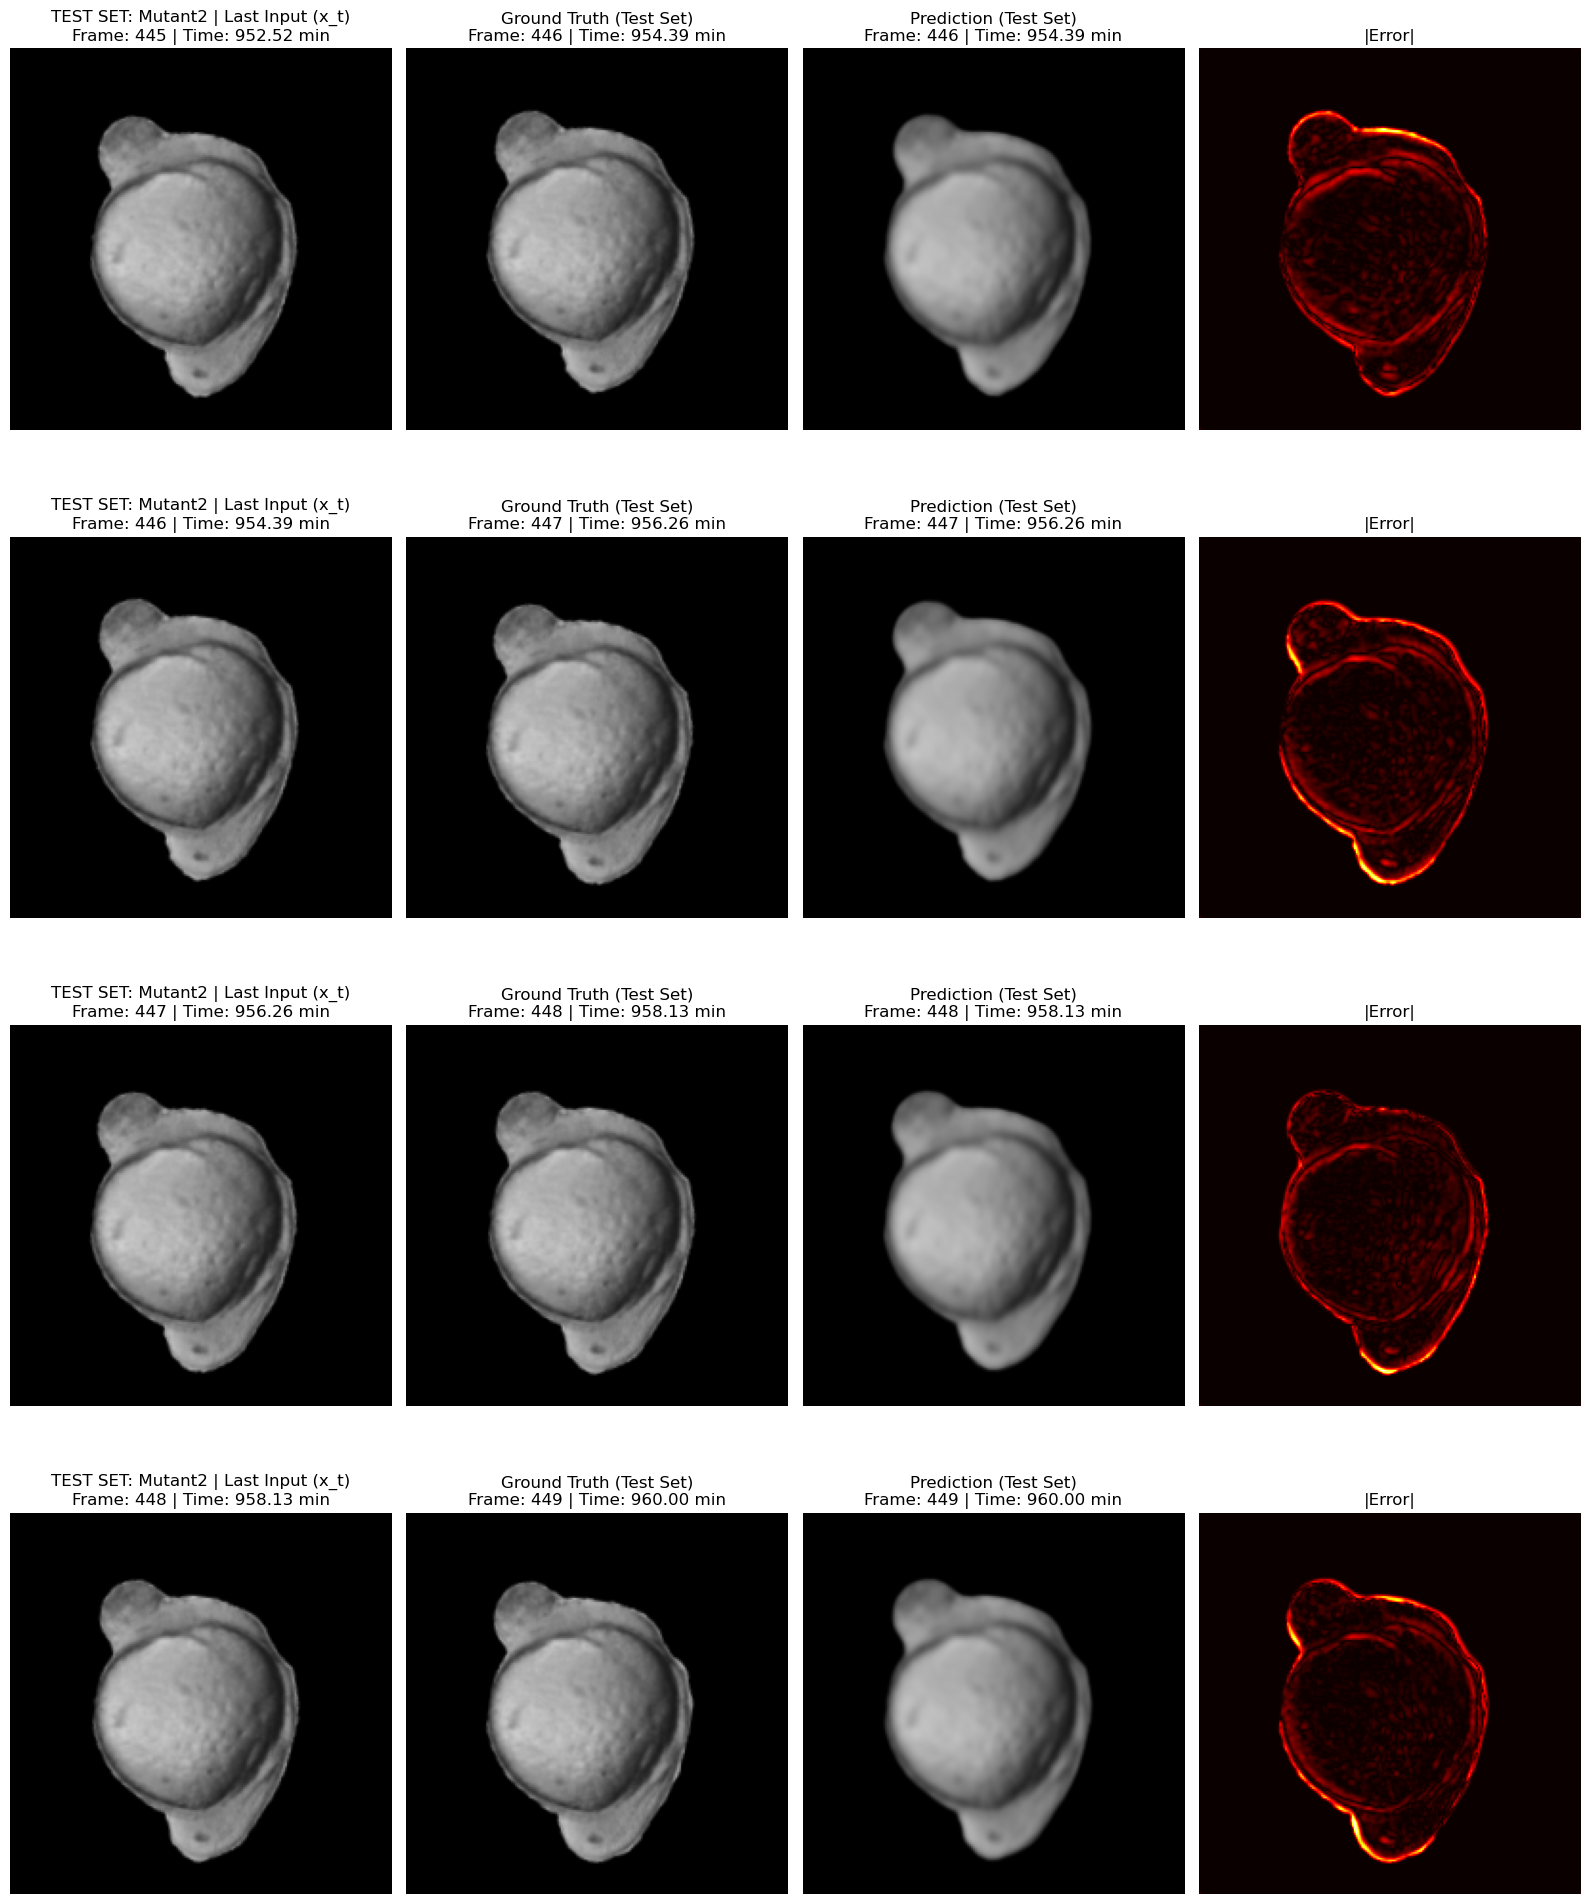

STARTING TEST FOR: Mutant4

  *** RESULT (Quantitative) ***
  -> Average Test Loss for Mutant4: 0.11085105
  -> (Equivalent SSIM: 0.8891)

  *** RESULT (Qualitative) ***
  -> Visualizing batch: 'last'...


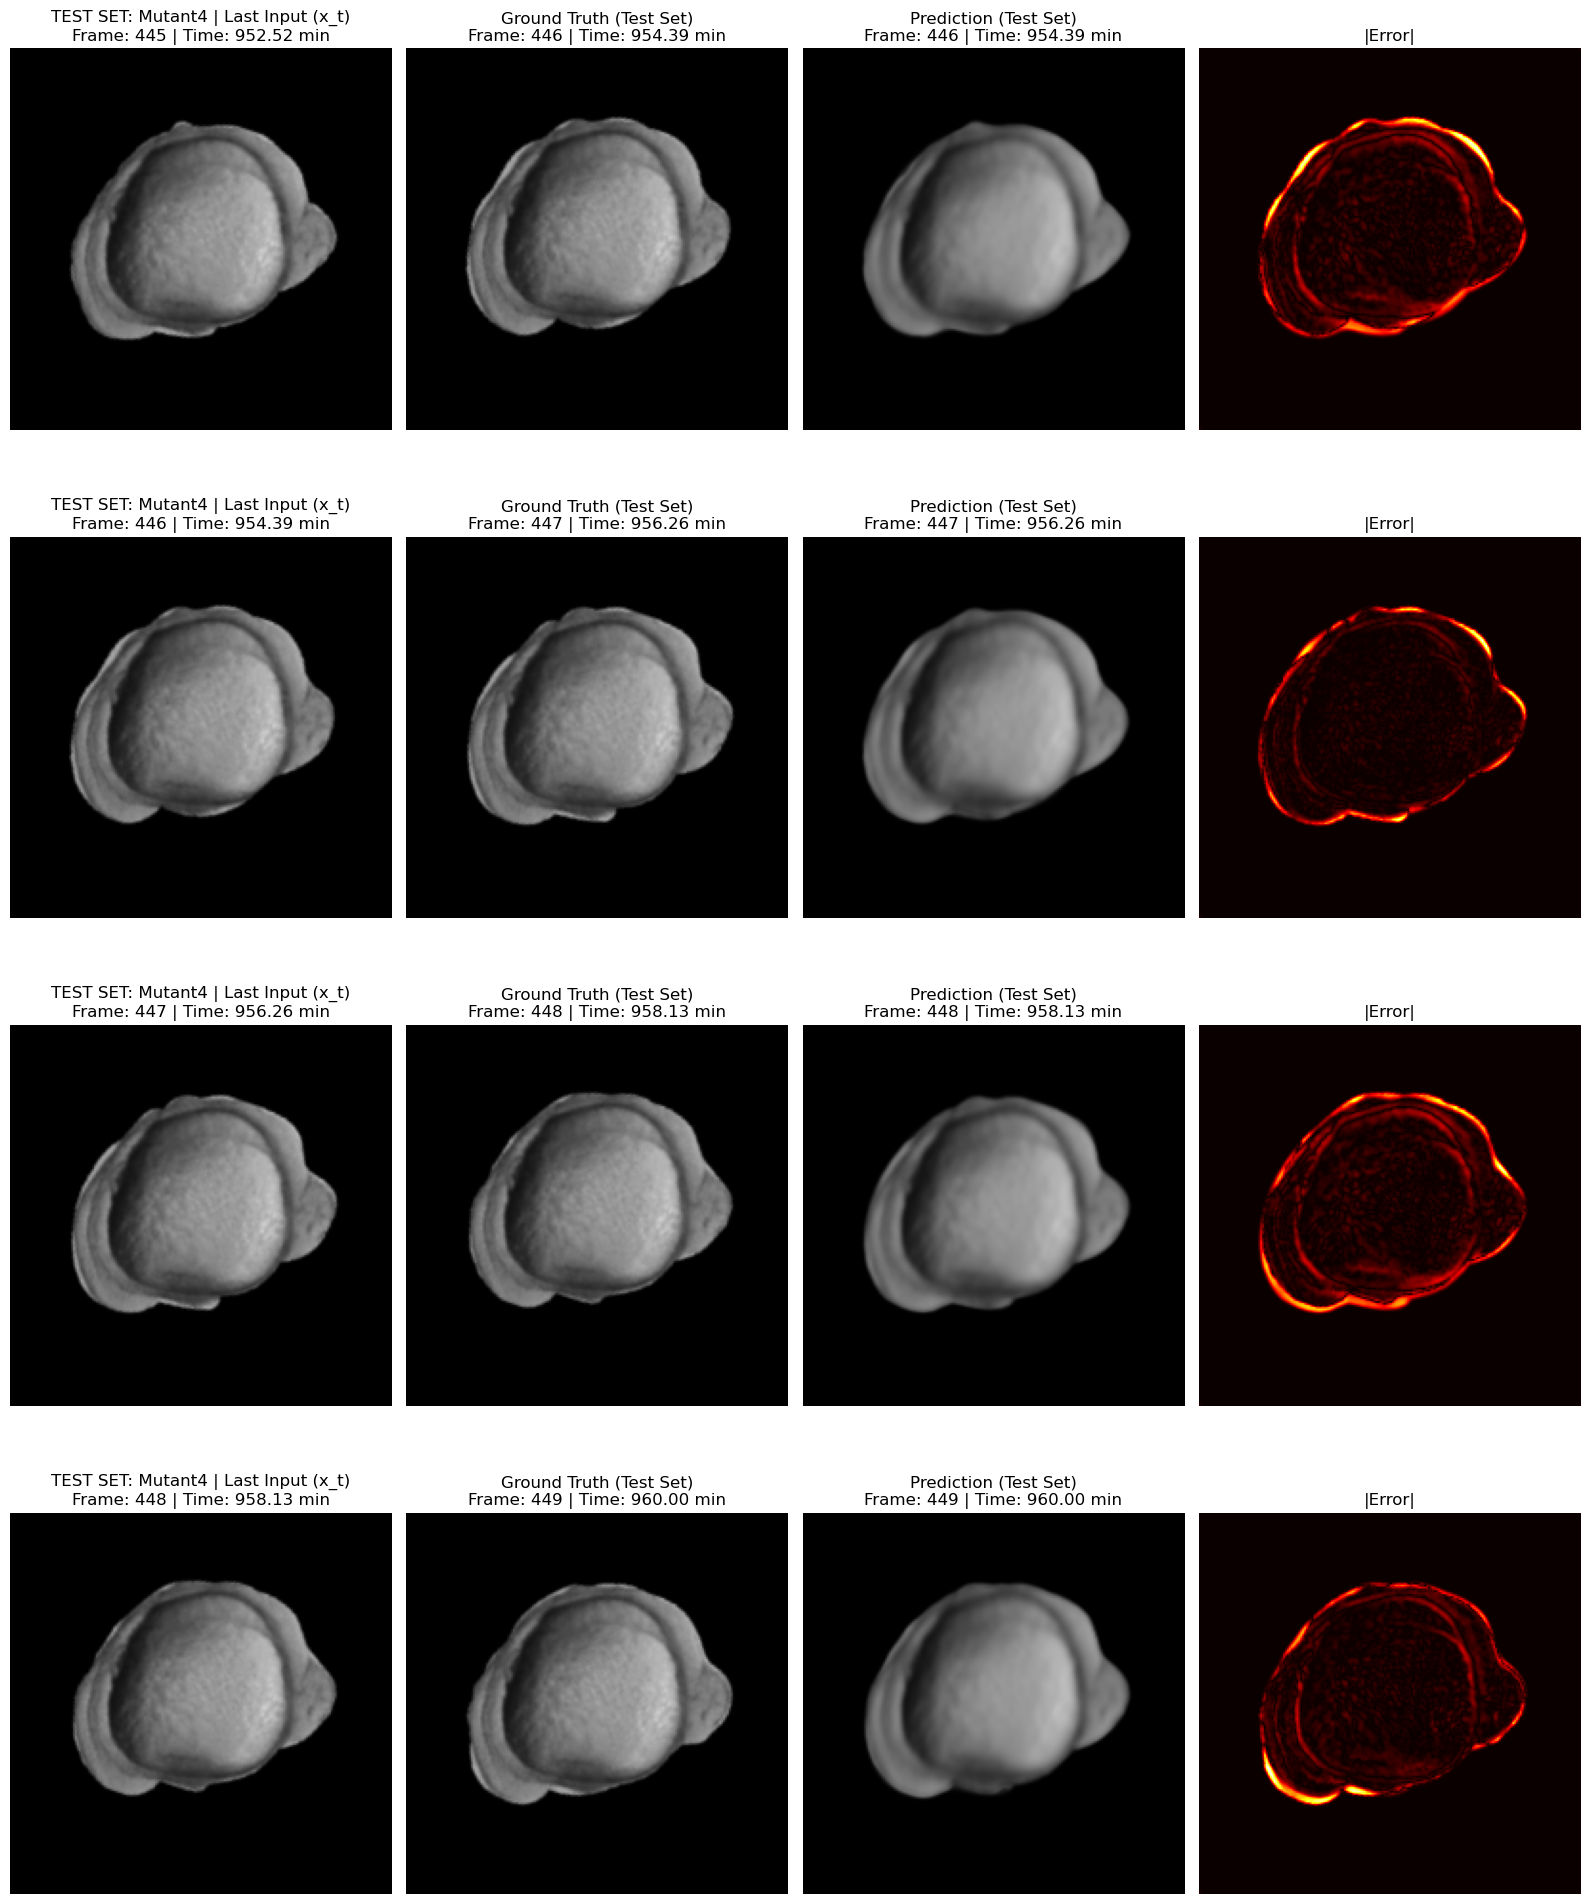

 FINAL TEST SUMMARY (Per-Embryo):
 -> Avg. Test Loss for Control2: 0.07112371
 -> Avg. Test Loss for Mutant2: 0.09604156
 -> Avg. Test Loss for Mutant4: 0.11085105

--- Final Losses Dictionary ---
{'Control2': 0.07112371488050981, 'Mutant2': 0.0960415623404763, 'Mutant4': 0.11085105321624063}


In [15]:
# We'll visualize the 'last' batch by default
final_losses = trainer.run_per_embryo_test_and_visualize(visualize_batch='last')

print("\n--- Final Losses Dictionary ---")
print(final_losses)